In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import matplotlib.ticker as ticker

def convert_tb_data(root_dir, sort_by=None):
    """Convert local TensorBoard data into Pandas DataFrame.
    
    Function takes the root directory path and recursively parses
    all events data.    
    If the `sort_by` value is provided then it will use that column
    to sort values; typically `wall_time` or `step`.
    
    *Note* that the whole data is converted into a DataFrame.
    Depending on the data size this might take a while. If it takes
    too long then narrow it to some sub-directories.
    
    Paramters:
        root_dir: (str) path to root dir with tensorboard data.
        sort_by: (optional str) column name to sort by.
    
    Returns:
        pandas.DataFrame with [wall_time, name, step, value] columns.
    
    """
    import pandas as pd
    from tensorflow.python.summary.summary_iterator import summary_iterator

    columns = [
        'train/daily_msc_step',
        'train/daily_ano_step',
        'train/loss_step',
        'epoch',
        'val/daily_msc',
        'val/daily_ano',
        'val/loss',
        'train/daily_msc_epoch',
        'train/daily_ano_epoch',
        'train/loss_epoch',
    ]

    def convert_tfevent(filepath):
        return pd.DataFrame([
            parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)
        ])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )
    
    columns_order = ['wall_time', 'name', 'step', 'value']
    
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by is not None:
        all_df = all_df.sort_values(sort_by)

    all_df = all_df.reset_index(drop=True)

    all_df = all_df.loc[all_df.name.isin(columns), :]
    all_df = all_df.drop_duplicates(subset=['name', 'step'], keep='last')
    all_df = pd.pivot(all_df, index='step', columns='name', values='value')

    return all_df

def load_tb_data(root_dir):

    out = []
    for dirname in glob.glob(os.path.join(root_dir, 'trial*')):
        df = convert_tb_data(dirname)
        idx = int(os.path.basename(dirname[-2:]))
        df['trial'] = idx
        out.append(df)

    out = pd.concat(out)

    out = out.rename(columns={
        'train/daily_ano_epoch': 'train_ano',
        'train/daily_ano_step': 'train_ano_step',
        'train/daily_msc_epoch': 'train_msc',
        'train/daily_msc_step': 'train_msc_step',
        'train/loss_epoch': 'train_loss',
        'train/loss_step': 'train_loss_step',
        'val/daily_ano': 'val_ano',
        'val/daily_msc': 'val_msc',
        'val/loss': 'val_loss',
        }
    )

    return out


In [152]:
d_tune = load_tb_data('../experiments/default/exp_00_2023-03-05_17-38-01/tune/')
d_cv = load_tb_data('../experiments/default/exp_00_2023-03-05_17-38-01/cv/')

In [153]:
def epoch_val(ds, key):
    return ds.loc[ds[key].notnull()]

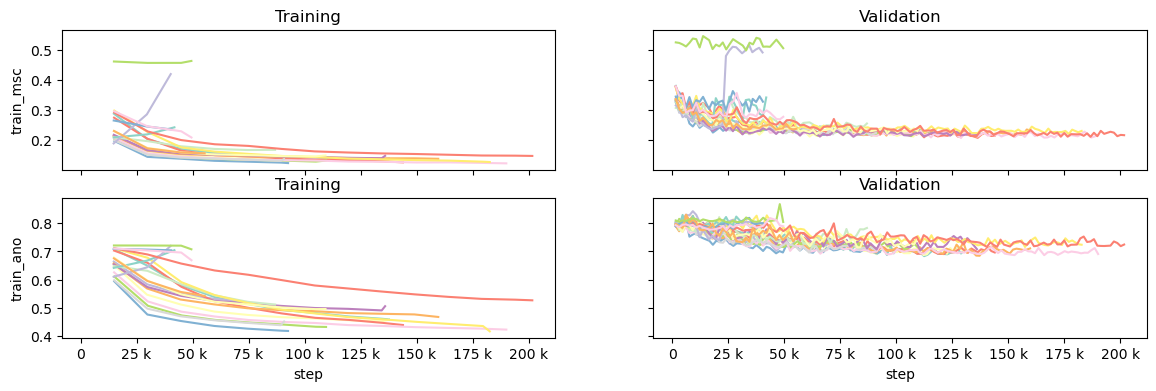

In [163]:
fig, axes = plt.subplots(2, 2, figsize=(14, 4), sharex=True, sharey='row')
sns.lineplot(data=epoch_val(d_tune, 'train_msc'), x='step', y='train_msc', hue='trial', palette='Set3', legend=False, ax=axes[0, 0]).set_title('Training')
sns.lineplot(data=epoch_val(d_tune, 'val_msc'), x='step', y='val_msc', hue='trial', palette='Set3', legend=False, ax=axes[0, 1]).set_title('Validation')
sns.lineplot(data=epoch_val(d_tune, 'train_ano'), x='step', y='train_ano', hue='trial', palette='Set3', legend=False, ax=axes[1, 0]).set_title('Training')
sns.lineplot(data=epoch_val(d_tune, 'val_ano'), x='step', y='val_ano', hue='trial', palette='Set3', legend=False, ax=axes[1, 1]).set_title('Validation')

for ax in axes.flatten():
    ax.xaxis.set_major_formatter(ticker.EngFormatter())

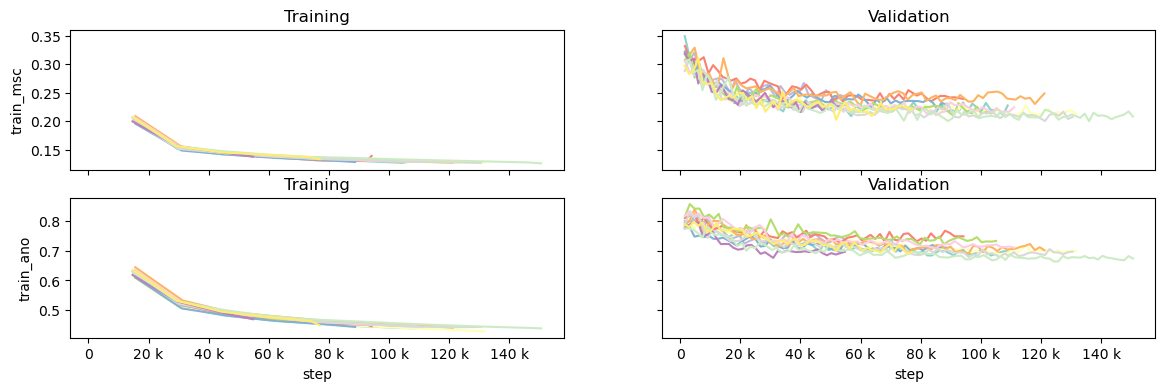

In [161]:
fig, axes = plt.subplots(2, 2, figsize=(14, 4), sharex=True, sharey='row')
sns.lineplot(data=epoch_val(d_cv, 'train_msc'), x='step', y='train_msc', hue='trial', palette='Set3', legend=False, ax=axes[0, 0]).set_title('Training')
sns.lineplot(data=epoch_val(d_cv, 'val_msc'), x='step', y='val_msc', hue='trial', palette='Set3', legend=False, ax=axes[0, 1]).set_title('Validation')
sns.lineplot(data=epoch_val(d_cv, 'train_ano'), x='step', y='train_ano', hue='trial', palette='Set3', legend=False, ax=axes[1, 0]).set_title('Training')
sns.lineplot(data=epoch_val(d_cv, 'val_ano'), x='step', y='val_ano', hue='trial', palette='Set3', legend=False, ax=axes[1, 1]).set_title('Validation')

for ax in axes.flatten():
    ax.xaxis.set_major_formatter(ticker.EngFormatter())